---

<center><h1> COM 405 Fall 2024: Mobile networks </h1></center>

<center><h2> Lab Assignment 1 </h2></center>

<center><h2> OFDM </h2></center>

---

This lab assignment is aimed towards teaching you how to transmit, capture, and decode OFDM symbols with software defined radios.
Specifically, we use USRPs (Universal Software Radio Peripheral).
Before starting the lab, please review the class lectures on OFDM.

The TA team collects and provides the data obtained from the USRPs directly and the students will focus only on how to decode the received OFDM packets.

---


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
path = r"/content/drive/MyDrive/Colab Notebooks"
os.chdir(path)
print(os.getcwd())

/content/drive/MyDrive/Colab Notebooks


# 1. OFDM Chain

In this lab, our goal is to understand and design an OFDM physical layer.
You will need to write the code for each block of the RX chain shown in Fig. 1.
The code for the TX chain in Fig. 1 will be provided to you.
The only purpose of providing the TX chain code to you is for you to understand how the packet was constructed.
Note that all the required data will be collected in the lab and provided directly to you.
You only need to implement the RX chain to decode the received OFDM packets.

The code ie written in Python.
We will provide you with the skeleton code and you will only need to modify in between the places where you see ``# Your Code Starts Here #`` and ``# Your Code Ends Here #``.
The lab will be divided into two parts.
In each part, you will need to perform some subtasks and generate corresponding output files and figures for evaluation.
For debugging purposes, we also provide some debugging signals with the expected output.
The final goal is to use the RX chain to decode the OFDM packets.

![image.png](attachment:ae26e26b-aff7-430b-a631-dd93493ec2fd.png)

The main directory consists of this file, ``OFDM_Lab.ipynb``, and two subfolders.
All the code that you have to write and execute will be written in this file.
Some cells of this file are the test scripts that will run your code on the test files and save the result for our evaluation.
Consequently, you do not need to modify those cells and you just have to run them to save the results.
Moreover, the test cells use some test data located at ``Mat_files`` directory.
<span style="color:red">
As a result, do not change the directories' name and location, otherwise the test scripts will not work and you will lose the points.
Same applies for the location of this file, ``OFDM_Lab.ipynb``.
</span>

<span style="color:red">

**Very Important Note:** The inputs and outputs of each function that you will write is specified before the function.
It is very important to comply with the type, shape, and the order of outputs specified before each function.
If you do not comply with them, the test scripts will not work or, even worth, it will work and output the wrong results.
In this case you will lose the points for that function and consecutive dependant tests.
Moreover, please pay attention to the order of the outputs if the function has more than one.

For the type of variables, for example if it is written ``numpy.ndarray: complex128``, it means that the variable should be a numpy array of complex128 variables.

</span>

As mentioned, there are two subfolders:

* **Mat_Files:** Test Signals for debugging and evaluation are provided in this file.
It has three subfolders ``Debug``, ``Test`` and ``RX_Data``.
The files in ``Debug`` are to help you debug your code.
The test scripts will use the files from the folder ``Test`` and we will evaluate your results on these data files.
The subfolder ``RX_Data`` contains the OFMD signals collected in the lab on USRPs.
The final goal is to be able to decode these packets using the receiver chain designed by you.

* **Results:** This folder is initially empty.
Gradually when you run the test scripts, more and more results will be saved in this folder.
You have to upload this folder as well for our evaluation.

In this lab, we will only work with BPSK modulation.
We will use the OFDM parameters corresponding to WiFi, as shown in Table 1.
The main difference is the center frequency.
We run our experiments at $f_c = 900 MHz$ instead of $2.4 GHz$ to avoid interference.
We also use a lower sampling rate.
In particular, we run our experiments with a sampling rate $f_s = 10 MHz$.
The test code, however, was generated with a sampling frequency of $f_t = 20 MHz$.
Hence for decoding the received packets from the USRP, you should use $f_s$.
For decoding test data and running test code, you should use $f_t$.

All parameters are stored in the matlab file ``Mat_Files/Parameters.mat``.
At the beginning of each cell that you should fill, we already loaded all the parameters from this file.
Note that not all of them might be needed for each cell.
We loaded them all to do not give hints about the implementation of the cells.

![image.png](attachment:b8e414c9-09fd-4c2a-8d68-81da50f94054.png)

## Helper Functions
All the helper functions that you can use in your code is provided in the following python cell.
Please do not forget to run the following cell, so that later cells can find these helper functions.

<span style="color:red">

It is very important to pay attention to the format of the inputs and outputs of these helper functions in order to use them.
As a result, please read the inputs and outputs format in the following cell before using the helper functions.

</span>


In [ ]:
"""
    @param normal_bin_index: The normal bin indices.
    For example you can input the "guard_bins" which is in the "parameters.mat" file to this function.
    @type  normal_bin_index: int16
    @shape normal_bin_index: (N,)

    @return num_bins: The number of bins.
    You can give the "num_bins" in the "parameters.mat" file to this function.
    @type num_bins: int

    @return fft_bin_index: The converted bin indices.
    @type fft_bin_index: int64
    @shape fft_bin_index: (N,)
"""
def convert_bin_index_normal_to_fft(normal_bin_index, num_bins):
    if num_bins % 2 == 0:
        normal_to_fft = np.concatenate((np.arange(num_bins//2, num_bins), np.arange(num_bins//2)))
        fft_bin_index = normal_to_fft[num_bins//2 + normal_bin_index]
    else:
        normal_to_fft = np.concatenate((np.arange((num_bins-1)//2, num_bins), np.arange((num_bins-1)//2)))
        fft_bin_index = normal_to_fft[(num_bins-1)//2 + normal_bin_index]

    return fft_bin_index

"""
    @param fft_bin_index: The fft bin indices as numpy.fft use.
    For example you can input the "guard_bins" which is in the "parameters.mat" file to this function.
    @type  fft_bin_index: int64
    @shape fft_bin_index: (M,)

    @return num_bins: The number of bins.
    You can give the "num_bins" in the "parameters.mat" file to this function.
    @type num_bins: int

    @return normal_bin_index: The converted bin indices.
    @type normal_bin_index: int64
    @shape normal_bin_index: (M,)
"""
def convert_bin_index_fft_to_normal(fft_bin_index, num_bins):
    if num_bins % 2 == 0:
        fft_to_normal = np.concatenate((np.arange(0, num_bins//2), np.arange(-1 * num_bins//2, 0)))
    else:
        fft_to_normal = np.concatenate((np.arange(0, (num_bins-1)//2 + 1), np.arange(-1 * (num_bins-1)//2, 0)))

    normal_bin_index = fft_to_normal[fft_bin_index]

    return normal_bin_index

# 2. Provided Data

The TA team has generated and transmitted OFDM packets through a USRP transmitter and captured the packets over the wireless channel using a USRP receiver.
The packets are captured at ten different locations in the lab and the received signal at each of these ten locations are provided in the directory ``Mat_Files/RX_Data``.
The received signal file is in the form of a ``.dat`` file, and it can be read using the function ``read_complex_binary2`` (provided at the required location in this file.)

In order to understand how the OFDM packets are generated, we provide the function, ``tx_ofdm_chain``, used for the packet generation in the following cell.
The function takes as input the data bits, and outputs the complex signal as per the TX chain in Fig. 1.
Please note that you do not need to modify or run the following cell.
The function is only provided to help you understand how the packet was constructed.

Some points to be noted for generating the OFDM packet are:

* There are 8 preamble symbols.
The first 4 are for packet detection.
The next 2 are for CFO estimation and the last 2 are for channel estimation.
* Cyclic Prefixes are added to the end of each data symbol.
For the preamble symbols however, the cyclic prefix is added only to the last preamble symbol.
This is because the preamble symbols are identical.
* In the modulation step, bit 0 maps to 1, and bit 1 maps to -1.
* Preamble symbols do not need pilots, and as a result the variable ``bits_preamble`` has 52 bits.
* Care must be taken to use the correct subcarrier indices.
Because of the fftshift, the index of the subcarriers in the numpy fft index (0 to 63) is not the same as its normal index (-32 to 31).
For example, the subcarrier with index -1 becomes 63 after the fftshift.
Use the supplied functions ``convert_bin_index_fft_to_normal`` and ``convert_bin_index_normal_to_fft`` to move between the two.
These functions are provided previously as helper functions.
To understand the usage better, look at the ``tx_ofdm_chain`` function.
* The variables bits_preamble, bits_data, and bits_pilots are all assigned as per the normal indexing of subcarriers.
For instance, the bits in the variable bits_pilots (1, 0, 1 and 0) should be assigned to subcarriers with indices -21, -7, 7 and 21 respectively.
Similar mapping between bits and subcarriers should take place for the preamble and data bits.
To understand this better, take a look at ``tx_ofdm_chain`` function.


In [ ]:
import numpy as np
from scipy.fft import ifft

# Note: This function is only provided for the purpose of understanding the TX chain.
# You do not need to run or modify it.
def tx_ofdm_chain(bits_data):
    # Load parameters from .mat file.
    params = scipy.io.loadmat('Mat_Files/Parameters.mat')
    num_bins = params['num_bins'].item()
    cp = params['cp'].item()
    fs = params['fs'].item()
    guard_bins = params['guard_bins'].flatten().astype(np.int16)
    pilots = params['pilots'].flatten().astype(np.int16)
    bits_preamble = params['bits_preamble'].flatten().astype(np.int16)
    bits_pilots = params['bits_pilots'].flatten().astype(np.int16)
    num_syms_data = params['num_syms_data'].item()
    num_bins_data = params['num_bins_data'].item()

    signal = np.zeros(num_samples)

    # Initialize symbol_freq and subcarrier_config
    symbol_freq = np.zeros(num_bins)
    subcarrier_config = np.ones(num_bins)

    subcarrier_config[convert_bin_index_normal_to_fft(guard_bins, num_bins)] = 0
    subcarrier_config[convert_bin_index_normal_to_fft(pilots, num_bins)] = 3

    # Add preamble symbols
    for m in range(num_syms_preamble):
        symbol_freq[subcarrier_config != 0] = 1 - 2 * np.fft.fftshift(bits_preamble)
        symbol_time = np.sqrt(num_bins) * ifft(symbol_freq)
        signal[m*num_bins:(m+1)*num_bins] = symbol_time.real

    signal[num_syms_preamble*num_bins:(num_syms_preamble*num_bins + cp)] = symbol_time[:cp].real

    # Add data symbols
    for m in range(num_syms_data):
        symbol_freq[subcarrier_config == 1] = 1 - 2 * np.fft.fftshift(bits_data[m*num_bins:(m+1)*num_bins])
        symbol_freq[subcarrier_config == 3] = 1 - 2 * np.fft.fftshift(bits_pilots)
        symbol_time = np.sqrt(num_bins) * ifft(symbol_freq)
        start = num_syms_preamble * num_bins + cp + m * (num_bins + cp)
        signal[start:start+num_bins+cp] = np.concatenate([symbol_time, symbol_time[:cp]]).real

    return signal

# 3. Part 1 - Receiver Chain Blocks

In this part, you will implement the various receiver chain blocks shown in Fig. 1.
This part is divided into the following subtasks.

## 3.1. Packet Detection

Implement the function ``packet_detection`` in the following cell.
It should take a complex signal as input and return the index of the first sample in the packet.
You can use the signals in ``Mat_Files/Debug/Packet_Detection.mat`` to check if your packet detection works. This file has two variables: ``signal`` which contains 100 different received complex wireless signals and ``start_index`` which contains the 100 corresponding indices to the start of each packet.
Depending on the exact parameters that you use, your packet detection output could vary slightly.
However this will not affect the ability to decode the packet due to the presence of cyclic prefixes as long as the offset in the packet start is less than a cyclic prefix.

Here are a few hints to help you.
* You can implement either the double sliding window algorithm or correlation to detect the start of the packet.
You know the preamble structure, so you can make use of that.
* In order to detect the start of the packet, you can use a threshold of 6.
You must however play around with this threshold to see if you can get a better packet detection.
Plot the signal superimposed with the packet start index to see how well your packet detection is performing.
* Make sure to add $(3/4)cp$ to the output of the function.

In [ ]:
import numpy as np
import scipy.io
from scipy.signal import lfilter

"""
    @param rx_signal: The input signal
    @type  rx_signal: numpy.ndarray: complex128
    @shape rx_signal: (N,)

    @return packet_start_index: packet's start index.
    @type packet_start_index: int
"""
def packet_detection(rx_signal, index_arr, val_arr):
    # Load parameters from .mat file. Note that all of them might not be needed for this cell.
    params = scipy.io.loadmat('Mat_Files/Parameters.mat')
    num_bins = params['num_bins'].item()
    cp = params['cp'].item()
    fs = params['fs'].item()
    guard_bins = params['guard_bins'].flatten().astype(np.int16)
    pilots = params['pilots'].flatten().astype(np.int16)
    bits_preamble = params['bits_preamble'].flatten().astype(np.int16)
    bits_pilots = params['bits_pilots'].flatten().astype(np.int16)
    num_syms_data = params['num_syms_data'].item()
    num_bins_data = params['num_bins_data'].item()

    # DC Removal Filter
    alpha = 0.975
    b = [1, -1]
    a = [1, -alpha]
    rx_signal = lfilter(b, a, rx_signal)

    threshold = 6

    # Your Code Starts Here #
    max_corr = 0
    packet_start_index = -1
    L = 2*len(bits_preamble) #window size
    last_chunk = (len(rx_signal)//L)*L - 2*L
    for i in range(0, last_chunk, 1):
      window_a = rx_signal[i:i+L]
      window_b = rx_signal[i+L:i+2*L]
      sum_a = np.sum(np.abs(window_a)**2)
      sum_b = np.sum(np.abs(window_b)**2)
      corr = sum_b/sum_a
      val_arr.append(corr)
      index_arr.append(i)
      if corr > threshold and corr > max_corr:
        max_corr = corr
        packet_start_index = i + 2*len(bits_preamble) #+ 0.75*cp #8 being the number of the preamble symbols

    return int(packet_start_index)

# Your Code Ends Here #


After implementing the function, run the following cell (no modification is needed) to save your results in the ``Results`` folder for our evaluation.

Make sure that your result ``Packet_Detection_Test.mat`` is saved after running this cell.

In [ ]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

def test_packet_detection():
    # Load data
    #packet_detection_data = scipy.io.loadmat('Mat_Files/Test/Packet_Detection.mat')
    packet_detection_data = scipy.io.loadmat('Mat_Files/Debug/Packet_Detection.mat')

    signal = packet_detection_data['signal']
    num_sigs, len_sigs = signal.shape

    packets_start_index_test = np.zeros(num_sigs)

    for m in range(num_sigs):
        index_arr = []
        val_arr = []
        packets_start_index_test[m] = packet_detection(signal[m, :len_sigs], index_arr, val_arr)
        print('Orig value: {}, my value: {}, diff: {}'.format(packet_detection_data['start_index'][m], packets_start_index_test[m], packet_detection_data['start_index'][m] - packets_start_index_test[m]))
        '''plt.plot(index_arr, val_arr, marker='o')
        plt.axvline(x=packet_detection_data['start_index'][m], color='red', linestyle='--')
        plt.axvline(packets_start_index_test[m], color='green', linestyle='--')
        plt.xlim(packet_detection_data['start_index'][m] - 500, packet_detection_data['start_index'][m] + 500)
        plt.grid(False)
        plt.show()'''

    # Save results
    scipy.io.savemat('Results/Packet_Detection_Test.mat', {'packets_start_index_test': packets_start_index_test})

test_packet_detection()

Orig value: [60913], my value: 60912.0, diff: [1.]
Orig value: [54211], my value: 54210.0, diff: [1.]
Orig value: [44729], my value: 44728.0, diff: [1.]
Orig value: [58224], my value: 58222.0, diff: [2.]
Orig value: [51110], my value: 51106.0, diff: [4.]
Orig value: [73709], my value: 73708.0, diff: [1.]
Orig value: [65370], my value: 65369.0, diff: [1.]
Orig value: [35055], my value: 35054.0, diff: [1.]
Orig value: [40765], my value: 40764.0, diff: [1.]
Orig value: [67854], my value: 67853.0, diff: [1.]
Orig value: [36818], my value: 36817.0, diff: [1.]
Orig value: [44839], my value: 44836.0, diff: [3.]
Orig value: [65828], my value: 65827.0, diff: [1.]
Orig value: [20483], my value: 20482.0, diff: [1.]
Orig value: [25064], my value: 25063.0, diff: [1.]
Orig value: [56324], my value: 56323.0, diff: [1.]
Orig value: [21416], my value: 21415.0, diff: [1.]
Orig value: [28490], my value: 28487.0, diff: [3.]
Orig value: [60118], my value: 60117.0, diff: [1.]
Orig value: [20494], my value: 

## 3.2. CFO Estimation and Correction

Implement the function ``estimate_cfo`` in the following cell.

The function should take as input two consecutive received OFDM symbols ($rx_1$ and $rx_2$), and output an estimate of the CFO.

Given the length of the OFDM symbol to be $L$ and a sampling rate of $f_s$, the CFO estimate can be given by the following equation.

![image.png](attachment:image.png)

In [ ]:
import numpy as np
import scipy.io

"""
    @param rx_sym1: The first input symbol
    @type  rx_sym1: numpy.ndarray: complex128
    @shape rx_sym1: (N,)

    @param rx_sym2: The second input symbol
    @type  rx_sym2: numpy.ndarray: complex128
    @shape rx_sym2: (N,)

    @param fs: The sampling rate
    @type  fs: int

    @return cfo: The CFO estimation
    @type cfo: numpy.float64: float64
    @shape: ()
"""
def estimate_cfo(rx_sym1, rx_sym2, fs):
    # Your Code Starts Here #
  #sum = np.sum(rx_sym1 * np.conjugate(rx_sym2))
  print("len rx1", len(rx_sym1))
  sum = 0
  for i in range(len(rx_sym1)):
    sum += rx_sym1[i] * np.conjugate(rx_sym2[i])
  print("sum: ", sum)
  estimate = (fs/(2*np.pi*len(rx_sym1)))*(np.angle(sum, deg=False))
  #print("Estimate_cfo: {} sum: {} ".format(estimate, sum))
  return estimate

# Your Code Ends Here #

Then, you must implement ``correct_cfo`` function in the following cell.
The function should take a signal in the time domain along with an estimate of the CFO and should output the signal compensating for the CFO across the samples.

In [ ]:
import numpy as np

"""
    @param rx_signal: The input signal that we want to correct its CFO
    @type  rx_signal: numpy.ndarray: complex128
    @shape rx_signal: (N,)

    @param cfo: The estimated CFO
    @type  cfo: numpy.float64: float64
    @shape  cfo: ()

    @param fs: The sampling rate
    @type  fs: int

    @return rx_signal_no_cfo: The CFO corrected signal
    @type rx_signal_no_cfo: numpy.ndarray: complex128
    @shape rx_signal_no_cfo: (N,)
"""
def correct_cfo(rx_signal, cfo, fs):
    # Your Code Starts Here #
  T = 1/fs
  print("fs: {}, 1/fs: {}, cfo: {}".format(fs, 1/fs, cfo))
  corrected_cfo = []
  #corrected_cfo = rx_signal * np.exp((0+1j) * 2 * np.pi * cfo * np.arange(len(rx_signal)) * T)
  for i in range(len(rx_signal)):
    corrected_cfo.append(rx_signal[i] * np.exp((0+1j) * 2 * np.pi * cfo * i * T))
  print("rx_signal: ", rx_signal.shape, " range ", np.arange(len(rx_signal)))
  print("np.exp...: ", np.exp((0+1j) * 2 * np.pi * cfo * np.arange(len(rx_signal)) * T))
  print("np.exp.shape: : ", (np.exp((0+1j) * 2 * np.pi * cfo * np.arange(len(rx_signal)) * T)).shape)
  print("rx_signal: ", rx_signal)
  return corrected_cfo

# Your Code Ends Here #

After implementing the function, run the following cell (no modification is needed) to save your results in the ``Results`` folder for our evaluation.

Make sure that your result ``Result_CFO_estimation.mat`` and ``Result_Cons_CFO_Corr.png`` are saved after running this cell.

len rx1 64
sum:  (51.80552493355219-4.4930597991907195j)
len rx1 64
sum:  (51.84803296381004-3.9725908150309817j)
len rx1 64
sum:  (51.830092957283135-4.20017428678735j)
len rx1 64
sum:  (51.824034126641926-4.274282026335379j)
len rx1 64
sum:  (51.685885102692374-5.706950249588919j)
len rx1 64
sum:  (51.75272007913542-5.065171705940173j)
len rx1 64
sum:  (51.697161147714596-5.603885193972896j)
len rx1 64
sum:  (51.8903961619962-3.37443123371788j)
len rx1 64
sum:  (51.768903143413056-4.897005955470884j)
len rx1 64
sum:  (51.822378411661596-4.294309695230712j)
len rx1 64
sum:  (51.80484140455485-4.500934019614432j)
len rx1 64
sum:  (51.605610708971675-6.392256515039735j)
len rx1 64
sum:  (51.713341766464076-5.452548334942306j)
len rx1 64
sum:  (51.844213108486386-4.022134652376604j)
len rx1 64
sum:  (51.793617335563084-4.6283045812978365j)
len rx1 64
sum:  (51.689775212710046-5.671608101720948j)
len rx1 64
sum:  (51.707449821534546-5.508142423130241j)
len rx1 64
sum:  (51.78765949980071-

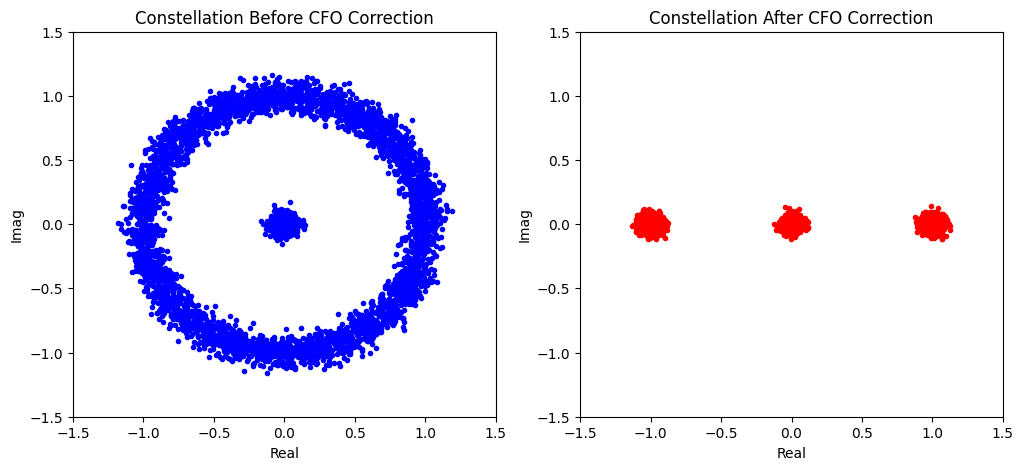

In [ ]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from scipy.io import loadmat, savemat
import sys
import time

def test_estimate_cfo():
    # Load parameters from .mat file. Note that all of them might not be needed for this cell.
    params = scipy.io.loadmat('Mat_Files/Parameters.mat')
    num_bins = params['num_bins'].item()
    # cp = params['cp'].item()
    fs = params['fs'].item()
    # guard_bins = params['guard_bins'].flatten().astype(np.int16)
    # pilots = params['pilots'].flatten().astype(np.int16)
    # bits_preamble = params['bits_preamble'].flatten().astype(np.int16)
    # bits_pilots = params['bits_pilots'].flatten().astype(np.int16)
    # num_syms_data = params['num_syms_data'].item()
    # num_bins_data = params['num_bins_data'].item()

    # Load the data and the signal within
    data = scipy.io.loadmat('Mat_Files/Test/Estimate_CFO_Test.mat')
    signal = data['signal']

    cfo_values = np.zeros(signal.shape[0])

    for m in range(signal.shape[0]):
        cfo_values[m] = estimate_cfo(signal[m, :num_bins], signal[m, num_bins:num_bins*2], fs)

    scipy.io.savemat('Results/Result_CFO_estimation.mat', {'cfo_values': cfo_values})


def test_correct_cfo():
    plt.close('all')
    # Load parameters from .mat file. Note that all of them might not be needed for this cell.
    params = scipy.io.loadmat('Mat_Files/Parameters.mat')
    num_bins = params['num_bins'].item()
    # cp = params['cp'].item()
    fs = params['fs'].item()
    # guard_bins = params['guard_bins'].flatten().astype(np.int16)
    # pilots = params['pilots'].flatten().astype(np.int16)
    # bits_preamble = params['bits_preamble'].flatten().astype(np.int16)
    # bits_pilots = params['bits_pilots'].flatten().astype(np.int16)
    # num_syms_data = params['num_syms_data'].item()
    # num_bins_data = params['num_bins_data'].item()

    # Load the data and the signal within
    cfo_test = loadmat('Mat_Files/Test/Correct_CFO_Test.mat')
    signal = cfo_test['signal'].flatten()

    # Estimate CFO
    cfo = estimate_cfo(signal[:num_bins], signal[num_bins:2*num_bins], fs)
    # Correct CFO
    signal_no_cfo = correct_cfo(signal, cfo, fs)

    # Save results
    savemat('Results/Result_CFO_Correction.mat', {'signal_no_cfo': signal_no_cfo, 'cfo': cfo})

    # Plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    ax1.set_ylabel('Imag')
    ax1.set_xlabel('Real')
    ax1.set_title('Constellation Before CFO Correction')
    ax1.set_ylim([-1.5, 1.5])
    ax1.set_xlim([-1.5, 1.5])

    ax2.set_ylabel('Imag')
    ax2.set_xlabel('Real')
    ax2.set_title('Constellation After CFO Correction')
    ax2.set_ylim([-1.5, 1.5])
    ax2.set_xlim([-1.5, 1.5])


    for m in range(len(signal) // num_bins):
        start = m * num_bins
        end = (m + 1) * num_bins

        fft_before = np.fft.fft(signal[start:end]) / np.sqrt(num_bins)
        fft_after = np.fft.fft(signal_no_cfo[start:end]) / np.sqrt(num_bins)

        ax1.plot(fft_before.real, fft_before.imag, '.b')
        ax2.plot(fft_after.real, fft_after.imag, '.r')

    plt.savefig('Results/Result_Cons_CFO_Corr.png')
    plt.show()

test_estimate_cfo()
test_correct_cfo()

## 3.3. Channel Estimation and Correction
Implement the function ``estimate_channel`` in the following cell.

The function should take as input two received OFDM preamble symbols and should output the complex wireless channel estimate.
While the channel estimation could be performed using just one received preamble symbol, you should use two here for averaging.

**Hint 1:** Do not forget the difference between the indices that numpy.fft uses (for example 0 to 63) and the normal indices (for example -31 to 31). The two functions to convert the normal indices to numpy.fft and vice versa are already given to you as the helper functions, so you can use them.

**Hint 2:** Make sure that you set the guard bins' value to zero in the estimated channel.
Moreover, always be alert about the guard bins to avoid dividing by zero.

In [ ]:
import numpy as np
import scipy.io

"""
    @param rx_sym1: The first preamble symbol
    @type  rx_sym1: numpy.ndarray: complex128
    @shape rx_sym1: (N,)

    @param rx_sym2: The second preamble symbol
    @type  rx_sym2: numpy.ndarray: complex128
    @shape rx_sym2: (N,)

    @return H: The estimated channel
    @type H: numpy.ndarray: complex128
    @shape H: (N,)
"""
def estimate_channel(rx_sym1, rx_sym2):
    # Load parameters from .mat file. Note that all of them might not be needed for this cell.
    params = scipy.io.loadmat('Mat_Files/Parameters.mat')
    num_bins = params['num_bins'].item()
    cp = params['cp'].item()
    fs = params['fs'].item()
    guard_bins = params['guard_bins'].flatten().astype(np.int16)
    pilots = params['pilots'].flatten().astype(np.int16)
    bits_preamble = params['bits_preamble'].flatten().astype(np.int16)
    bits_pilots = params['bits_pilots'].flatten().astype(np.int16)
    num_syms_data = params['num_syms_data'].item()
    num_bins_data = params['num_bins_data'].item()

    sym1_fft = np.fft.fft(rx_sym1)
    sym2_fft = np.fft.fft(rx_sym2)

    print("guard bins: ", guard_bins)
    full_range = np.arange(-32, 31)
    preamble_index = np.setdiff1d(full_range, guard_bins)
    print("preable bits: ", bits_preamble)
    print("preamble indices: ", preamble_index)
    print("len preamble bit: ", len(bits_preamble))
    print("len preamble indices: ", len(preamble_index))

    X_f0 = [None] * num_bins
    X_f = np.array(X_f0)
    guard_bin_fft_index = convert_bin_index_normal_to_fft(guard_bins, num_bins)
    X_f[guard_bin_fft_index] = 0

    print("Guard bin index after conversion to fft: ", guard_bin_fft_index)
    print("X_f with guard bins: ")
    print(X_f)

    for i in range(len(bits_preamble)):
      X_f[convert_bin_index_normal_to_fft(preamble_index[i], num_bins)] = 1 - 2*bits_preamble[i]
    print("After modulation: ")
    print(X_f)

    Y1_Y2_sum = sym1_fft + sym2_fft
    X_sum = 2*X_f
    H_f = []
    print("Len Y1_Y2_sum: {} X_sum: {}", len(Y1_Y2_sum), len(X_sum))
    for i in range(len(Y1_Y2_sum)):
      if i in guard_bin_fft_index and X_sum[i] == 0:
        print("Skipping i: ", i)
        H_f.append(0)
      elif i in guard_bin_fft_index and X_sum[i] != 0:
        print("Error for guard bin i ", i, "having value ", X_sum[i])
      else:
        H_f.append(Y1_Y2_sum[i]/X_sum[i])

    print("H_f len {} H_f: {}", len(H_f), H_f)
    return np.array(H_f)


    # Your Code Starts Here #

# Your Code Ends Here #
#dtype=np.complex_


After that, implement the function ``correct_channel`` in the following cell.

The function should take an OFDM symbol in the frequency domain along with an estimate of the channel and should output the symbol after compensating for the channel.

**Hint:** Again, make sure that you set the guard bins' value to zero in the compensated signal, and avoid dividing by zero.

In [ ]:
import numpy as np
from scipy.io import loadmat

"""
    @param rx_sym: The input symbol
    @type  rx_sym: numpy.ndarray: complex128
    @shape rx_sym: (N,)

    @param H: The estimation of the channel
    @type  H: numpy.ndarray: complex128
    @shape H: (N,)

    @return rx_sym_no_channel: The channel compensated symbol
    @type rx_sym_no_channel: numpy.ndarray: complex128
    @shape rx_sym_no_channel: (N,)
"""
def correct_channel(rx_sym, H):
    # Load parameters from .mat file. Note that all of them might not be needed for this cell.
    params = scipy.io.loadmat('Mat_Files/Parameters.mat')
    num_bins = params['num_bins'].item()
    cp = params['cp'].item()
    fs = params['fs'].item()
    guard_bins = params['guard_bins'].flatten().astype(np.int16)
    pilots = params['pilots'].flatten().astype(np.int16)
    bits_preamble = params['bits_preamble'].flatten().astype(np.int16)
    bits_pilots = params['bits_pilots'].flatten().astype(np.int16)
    num_syms_data = params['num_syms_data'].item()
    num_bins_data = params['num_bins_data'].item()


    guard_bin_fft_index = convert_bin_index_normal_to_fft(guard_bins, num_bins)
    res_rx = [0] * num_bins
    res_rx = np.array(res_rx, dtype='complex128')
    for i in range (len(rx_sym)):
      if i in guard_bin_fft_index and H[i] == 0:
        print("Skipping i: ", i)
        res_rx[i] = 0
      elif i in guard_bin_fft_index and H[i] != 0:
        print("Error for guard bin i ", i, "having value ", H[i])
      else:
        res_rx[i] = rx_sym[i]/H[i]

    print("Res_rx: ", res_rx)
    rx_sym_no_channel = res_rx
    # Your Code Starts Here #
    return rx_sym_no_channel
# Your Code Ends Here #

After implementing the functions, run the following cell (no modification is needed) to save your results in the ``Results`` folder for our evaluation.

Make sure the results, ``Result_Channel_Estimation.mat``, ``Result_Channel.png``, and ``Result_Cons_Channel_Corr.png`` are saved after running this cell.

guard bins:  [-32 -31 -30 -29 -28 -27   0  27  28  29  30  31]
preable bits:  [0 1 1 0 0 1 0 1 0 1 1 1 1 1 0 0 1 1 0 1 0 1 0 0 0 0 0 0 1 1 0 0 1 0 1 0 0
 0 0 0 0 1 1 0 0 1 0 1 0 0 0 0]
preamble indices:  [-26 -25 -24 -23 -22 -21 -20 -19 -18 -17 -16 -15 -14 -13 -12 -11 -10  -9
  -8  -7  -6  -5  -4  -3  -2  -1   1   2   3   4   5   6   7   8   9  10
  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26]
len preamble bit:  52
len preamble indices:  52
Guard bin index after conversion to fft:  [32 33 34 35 36 37  0 27 28 29 30 31]
X_f with guard bins: 
[0 None None None None None None None None None None None None None None
 None None None None None None None None None None None None 0 0 0 0 0 0 0
 0 0 0 0 None None None None None None None None None None None None None
 None None None None None None None None None None None None None]
After modulation: 
[0 1 1 -1 -1 1 1 -1 1 -1 1 1 1 1 1 1 -1 -1 1 1 -1 1 -1 1 1 1 1 0 0 0 0 0 0
 0 0 0 0 0 1 -1 -1 1 1 -1 1 -1 1 -1 -1 -1 -1 -1 1 1

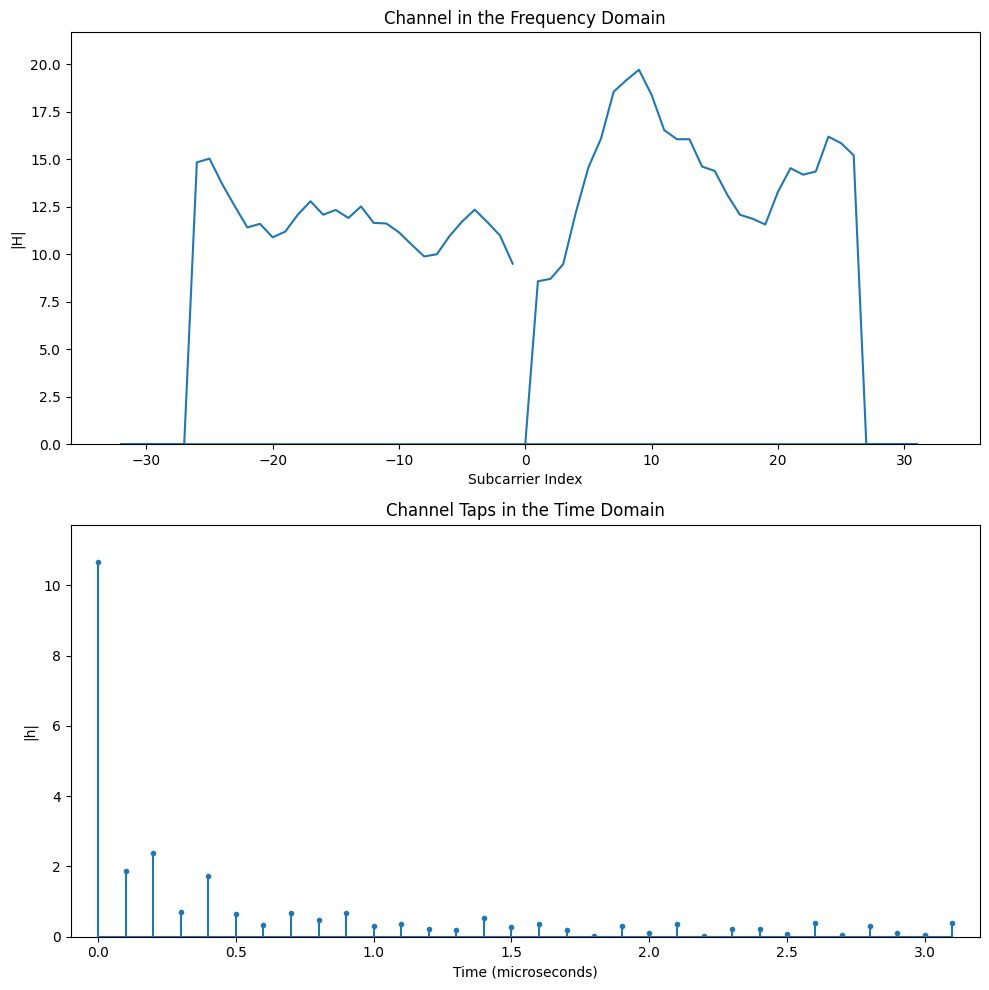

guard bins:  [-32 -31 -30 -29 -28 -27   0  27  28  29  30  31]
preable bits:  [0 1 1 0 0 1 0 1 0 1 1 1 1 1 0 0 1 1 0 1 0 1 0 0 0 0 0 0 1 1 0 0 1 0 1 0 0
 0 0 0 0 1 1 0 0 1 0 1 0 0 0 0]
preamble indices:  [-26 -25 -24 -23 -22 -21 -20 -19 -18 -17 -16 -15 -14 -13 -12 -11 -10  -9
  -8  -7  -6  -5  -4  -3  -2  -1   1   2   3   4   5   6   7   8   9  10
  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26]
len preamble bit:  52
len preamble indices:  52
Guard bin index after conversion to fft:  [32 33 34 35 36 37  0 27 28 29 30 31]
X_f with guard bins: 
[0 None None None None None None None None None None None None None None
 None None None None None None None None None None None None 0 0 0 0 0 0 0
 0 0 0 0 None None None None None None None None None None None None None
 None None None None None None None None None None None None None]
After modulation: 
[0 1 1 -1 -1 1 1 -1 1 -1 1 1 1 1 1 1 -1 -1 1 1 -1 1 -1 1 1 1 1 0 0 0 0 0 0
 0 0 0 0 0 1 -1 -1 1 1 -1 1 -1 1 -1 -1 -1 -1 -1 1 1

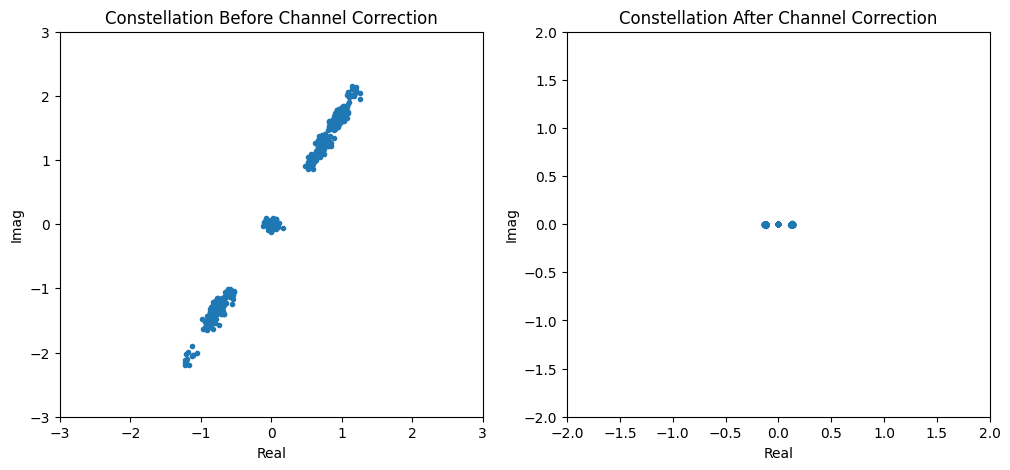

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat, savemat
from scipy.fft import ifft

def test_estimate_channel():
    plt.close('all')
    # Load parameters from .mat file. Note that all of them might not be needed for this cell.
    params = scipy.io.loadmat('Mat_Files/Parameters.mat')
    num_bins = params['num_bins'].item()
    # cp = params['cp'].item()
    fs = params['fs'].item()
    guard_bins = params['guard_bins'].flatten().astype(np.int16)
    # pilots = params['pilots'].flatten().astype(np.int16)
    # bits_preamble = params['bits_preamble'].flatten().astype(np.int16)
    # bits_pilots = params['bits_pilots'].flatten().astype(np.int16)
    # num_syms_data = params['num_syms_data'].item()
    # num_bins_data = params['num_bins_data'].item()

    # Load the data and the signal within
    channel_test = loadmat('Mat_Files/Test/Channel_Test.mat')
    signal = channel_test['signal'].flatten()

    # Estimate channel
    H = estimate_channel(signal[:num_bins], signal[num_bins:2*num_bins])
    print("H after estimation: ")
    print(H)

    # Save result
    savemat('Results/Result_Channel_Estimation.mat', {'H': H})

    print("BEFORE ERROR:")
    print(convert_bin_index_normal_to_fft(guard_bins, num_bins))
    print("LEN(H): ", len(H))
    # Process channel data
    H[convert_bin_index_normal_to_fft(guard_bins, num_bins)] = 0
    ht = ifft(H)

    # Plot results
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
    ax1.plot(convert_bin_index_fft_to_normal(np.arange(0, num_bins), num_bins), np.abs(H))
    ax1.set_ylabel('|H|')
    ax1.set_xlabel('Subcarrier Index')
    ax1.set_title('Channel in the Frequency Domain')
    ax1.set_xlim([-36, 36])
    ax1.set_ylim([min(np.abs(H[~np.isnan(H)]))*0.9, max(np.abs(H[~np.isnan(H)]))*1.1])

    time_axis = np.arange(num_bins//2) * 1e6 / fs
    ax2.stem(time_axis, np.abs(ht[:num_bins//2]), linefmt='C0-', markerfmt='C0.', basefmt='C0-')
    ax2.set_ylabel('|h|')
    ax2.set_xlabel('Time (microseconds)')
    ax2.set_title('Channel Taps in the Time Domain')
    ax2.set_xlim([-1e6/fs, (num_bins/2)*1e6/fs])
    ax2.set_ylim([0, np.abs(ht[0])*1.1])

    plt.tight_layout()
    plt.savefig('Results/Result_Channel.png')
    plt.show()
    plt.close()

def test_correct_channel():
    # Load parameters from .mat file. Note that all of them might not be needed for this cell.
    params = scipy.io.loadmat('Mat_Files/Parameters.mat')
    num_bins = params['num_bins'].item()
    # cp = params['cp'].item()
    # fs = params['fs'].item()
    # guard_bins = params['guard_bins'].flatten().astype(np.int16)
    # pilots = params['pilots'].flatten().astype(np.int16)
    # bits_preamble = params['bits_preamble'].flatten().astype(np.int16)
    # bits_pilots = params['bits_pilots'].flatten().astype(np.int16)
    # num_syms_data = params['num_syms_data'].item()
    # num_bins_data = params['num_bins_data'].item()

    # Load the data and the signal within
    channel_test = loadmat('Mat_Files/Test/Channel_Test.mat')
    signal = channel_test['signal'].flatten()

    H = estimate_channel(signal[:num_bins], signal[num_bins:2*num_bins])

    ss = []
    sc = []
    for m in range(0, len(signal), num_bins):
        sym_freq = (1/np.sqrt(num_bins)) * np.fft.fft(signal[m:m+num_bins])
        ss.append(sym_freq)

        sym_freq_no_channel = correct_channel(sym_freq, H)
        sc.append(sym_freq_no_channel)

    ss = np.concatenate(ss)
    sc = np.concatenate(sc)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    ax1.plot(ss.real, ss.imag, '.')
    ax1.set_ylabel('Imag')
    ax1.set_xlabel('Real')
    ax1.set_title('Constellation Before Channel Correction')
    ax1.axis([-3, 3, -3, 3])

    ax2.plot(sc.real, sc.imag, '.')
    ax2.set_ylabel('Imag')
    ax2.set_xlabel('Real')
    ax2.set_title('Constellation After Channel Correction')
    ax2.axis([-2, 2, -2, 2])

    plt.savefig('Results/Result_Cons_Channel_Corr.png')
    plt.show()


test_estimate_channel()
test_correct_channel()

## 3.4. Phase Tracking
Implement the function ``estimate_residual_cfo_sfo`` in the following cell.
The function should take as input a received OFDM symbol in the frequency domain along with an estimate of the channel and should output an estimate of the residual CFO and SFO using the pilot bits.

Recall that for an OFDM symbol of length L with C cyclic prefix samples, the residual CFO is the y-intercept and the residual SFO is the slope of the phase as a function of the frequency bins.
It can be calculated as the following equations.

![image.png](attachment:image.png)

Here are a few hints to help you.

* In phase tracking, when estimating the slope, make sure that the indices of the pilot subcarriers are in the normal mode.

* In phase tracking, use linear regression to estimate the slope of the phase. You are free to use Numpy functions that do it for you.

In [ ]:
import numpy as np
import scipy.io

"""
    @param rx_sym: The input symbol
    @type  rx_sym: numpy.ndarray: complex128
    @shape rx_sym: (N,)

    @param h: The estimation of the channel
    @type  h: numpy.ndarray: complex128
    @shape h: (N,)

    @return r_cfo, r_sfo: Two outputs respectively representing the residual cfo and residual sfo. Make sure to output them with the same order specified.
    @type r_cfo, r_sfo: numpy.float64: float64, numpy.float64: float64
    @shape r_cfo, r_sfo: (), ()
"""
def estimate_residual_cfo_sfo(rx_sym, h):
    # Load parameters from .mat file. Note that all of them might not be needed for this cell.
    params = scipy.io.loadmat('Mat_Files/Parameters.mat')
    num_bins = params['num_bins'].item()
    cp = params['cp'].item()
    fs = params['fs'].item()
    guard_bins = params['guard_bins'].flatten().astype(np.int16)
    pilots = params['pilots'].flatten().astype(np.int16)
    bits_preamble = params['bits_preamble'].flatten().astype(np.int16)
    bits_pilots = params['bits_pilots'].flatten().astype(np.int16)
    num_syms_data = params['num_syms_data'].item()
    num_bins_data = params['num_bins_data'].item()

    # Your Code Starts Here #

# Your Code Ends Here #

Then, implement the function ``correct_residual_cfo_sfo`` in the following cell.
The function should take as input an estimate of the channel along with the residual CFO and SFO and should output a new estimate of the channel after compensating for the CFO and SFO.

Here are some hints:
* Incorporate the phase tracking correction in the channel value, that is, update the channel 'h' from symbol to symbol so that the phase does not accumulate so much that it starts wrapping around 2π.
This will also allow you to automatically correct for the initial channel as well as all the accumulated phase when you run the ``correct_channel`` function.

* Again, make sure to set the unused subcarriers to zero.

In [ ]:
import numpy as np
import scipy.io

"""
    @param h_prev: Estimation of the channel
    @type  h_prev: numpy.ndarray: complex128
    @shape h_prev: (N,)

    @param r_cfo: Residual CFO
    @type  r_cfo: numpy.float64: float64
    @shape r_cfo: ()

    @param r_sfo: Residual SFO
    @type  r_sfo: numpy.float64: float64
    @shape r_sfo: ()

    @return h_new: New estimation of the channel after compensating for CFO and SFO
    @type h_new: numpy.ndarray: complex128
    @shape h_new: (N,)
"""
def correct_residual_cfo_sfo(h_prev, r_cfo, r_sfo):
    # Load parameters from .mat file. Note that all of them might not be needed for this cell.
    params = scipy.io.loadmat('Mat_Files/Parameters.mat')
    num_bins = params['num_bins'].item()
    cp = params['cp'].item()
    fs = params['fs'].item()
    guard_bins = params['guard_bins'].flatten().astype(np.int16)
    pilots = params['pilots'].flatten().astype(np.int16)
    bits_preamble = params['bits_preamble'].flatten().astype(np.int16)
    bits_pilots = params['bits_pilots'].flatten().astype(np.int16)
    num_syms_data = params['num_syms_data'].item()
    num_bins_data = params['num_bins_data'].item()

    # Your Code Starts Here #

# Your Code Ends Here #

After implementing the functions, run the following cell (no modification is needed) to save your results in the ``Result`` folder for our evaluation.

Make sure the results, ``Result_Cons_Phase_Track.png`` and ``Result_Phase_Tracking.mat`` are saved after running this cell.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

def test_phase_tracking():
    # Load parameters from .mat file. Note that all of them might not be needed for this cell.
    params = scipy.io.loadmat('Mat_Files/Parameters.mat')
    num_bins = params['num_bins'].item()
    cp = params['cp'].item()
    # fs = params['fs'].item()
    # guard_bins = params['guard_bins'].flatten().astype(np.int16)
    # pilots = params['pilots'].flatten().astype(np.int16)
    # bits_preamble = params['bits_preamble'].flatten().astype(np.int16)
    # bits_pilots = params['bits_pilots'].flatten().astype(np.int16)
    num_syms_data = params['num_syms_data'].item()
    # num_bins_data = params['num_bins_data'].item()

    # Load the data and the info within
    data = scipy.io.loadmat('Mat_Files/Test/Test_Phase_Tracking.mat')
    signal = data['signal'].flatten()
    h = data['h'].flatten()
    h_f = data['h_f'].flatten()

    cfo_r = np.zeros(num_syms_data)
    sfo_r = np.zeros(num_syms_data)

    # Plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    ax1.set_ylabel('Imag')
    ax1.set_xlabel('Real')
    ax1.set_title('Constellation Without Phase Tracking')
    ax1.set_ylim([-1.5, 1.5])
    ax1.set_xlim([-1.5, 1.5])

    ax2.set_ylabel('Imag')
    ax2.set_xlabel('Real')
    ax2.set_title('Constellation With Phase Tracking')
    ax2.set_ylim([-1.5, 1.5])
    ax2.set_xlim([-1.5, 1.5])

    for m in range(0, num_syms_data):
        sym = (1 / np.sqrt(num_bins)) * np.fft.fft(signal[int((num_bins + cp) * m):int(num_bins * (m + 1) + cp * m)])
        cfo_r[m], sfo_r[m] = estimate_residual_cfo_sfo(sym, h)
        h = correct_residual_cfo_sfo(h, cfo_r[m], sfo_r[m])

        cons_wo_tracking = np.zeros(sym.shape, dtype=np.complex128)
        cons_wo_tracking[np.nonzero(h_f)] = sym[np.nonzero(h_f)] / h_f[np.nonzero(h_f)]
        ax1.plot(cons_wo_tracking.real, cons_wo_tracking.imag, '.b')

        cons_wi_tracking = np.zeros(sym.shape, dtype=np.complex128)
        cons_wi_tracking[np.nonzero(h)] = sym[np.nonzero(h)] / h[np.nonzero(h)]
        ax2.plot(cons_wi_tracking.real, cons_wi_tracking.imag, '.r')

    plt.savefig('Results/Result_Cons_Phase_Track.png')
    plt.show()
    scipy.io.savemat('Results/Result_Phase_Tracking.mat', {'sfo_r': sfo_r, 'cfo_r': cfo_r})

test_phase_tracking()

## 3.5. RX Chain

Implement the function ``rx_ofdm_chain`` in the following cell.
Pay attention to the comments provided in the cell.
The comments are meant to help you separate different parts of the chain using the functions you already wrote.

The ``rx_ofdm_chain`` function should take as input a complex signal and output the data bits.
While generating the data bits, be careful about accounting for the conversion between fft indices and normal indices.

Here are a few hints to help you.
* Make sure to compensate for the cyclic prefix before you run the FFT in the RX chain.
Before you process a data symbol, make sure to skip one cyclic prefix.
* Make sure to skip enough samples (3/4 of the cyclic prefix) at the beginning to avoid inter-symbol interference at the start of processing the packet.
* Do not forget to ignore the guard and pilot bins when decoding.
These bins carry no data.

To test and debug your code, you can use the file ``Mat_Files/Debug/RX_chain.mat``.
This file has 2 variables: ``bits`` and ``signal``.
The $i^{th}$ row of ``bits`` corresponds to the decoded data bits of the $i^{th}$ row in ``signal``.

Note: It might take some time for the decoding process depending on your implementation.
Although we do not care about the running time of your code, you might need to be patient for your code to finish execution.

Reminder: Please pay attention to the desired output type of the function (bool in this case).
If the type is not correct, we might not be able to evaluate your results.  

In [ ]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt

"""
    @param rx_signal: The input signal
    @type  rx_signal: numpy.ndarray: complex128
    @shape rx_signal: (N,)

    @return bits_data: The decoded bits of the input signal
    @type bits_data: numpy.ndarray: bool
    @shape bits_data: (M,)
"""
def rx_ofdm_chain(rx_signal):
    # Load parameters from .mat file. Note that all of them might not be needed for this cell.
    params = scipy.io.loadmat('Mat_Files/Parameters.mat')
    num_bins = params['num_bins'].item()
    cp = params['cp'].item()
    fs = params['fs'].item()
    guard_bins = params['guard_bins'].flatten().astype(np.int16)
    pilots = params['pilots'].flatten().astype(np.int16)
    bits_preamble = params['bits_preamble'].flatten().astype(np.int16)
    bits_pilots = params['bits_pilots'].flatten().astype(np.int16)
    num_syms_data = params['num_syms_data'].item()
    num_bins_data = params['num_bins_data'].item()

    # Your Code Starts Here #

    if rx_signal.ndim == 1:
        rx_signal = rx_signal.reshape(1, -1)

    bits_data = []

    # This variable is meant to help differentiate the data subcarriers from pilot and unused subcarriers
    subcarrier_config = np.ones(num_bins)
    subcarrier_config[convert_bin_index_normal_to_fft(guard_bins, num_bins)] = 0
    subcarrier_config[convert_bin_index_normal_to_fft(pilots, num_bins)] = 3

    # This variable is meant to keep track at which sample you are in a packet
    current_index = 0
    index_arr = []
    val_arr = []

    ###### Packet detection
    # Add your code here
    mid_preamble_idx = packet_detection(rx_signal, index_arr, val_arr) #points to the start of the 5th preamble symbol



    ###### CFO estimation and correction
    # Add your code here
    cfo_value = estimate_cfo(rx_signal[mid_preamble_idx : mid_preamble_idx+len(bits_preamble)], rx_signal[mid_preamble_idx+len(bits_preamble), mid_preamble_idx+2*len(bits_preamble)], fs)
    Y1_cfo = rx_signal[mid_preamble_idx+2*len(bits_preamble), mid_preamble_idx+3*len(bits_preamble)]
    Y2_cfo = rx_signal[mid_preamble_idx+3*len(bits_preamble), mid_preamble_idx+4*len(bits_preamble)]
    Y1_no_cfo = correct_cfo(Y1_cfo, cfo_value, fs)
    Y2_no_cfo = correct_cfo(Y2_cfo, cfo_value, fs)


    ###### Channel estimation
    # Add your code here
    channel_estimation = estimate_channel(Y1_no_cfo, Y2_no_cfo)

    current_index = mid_preamble_idx+4*len(bits_preamble) + 0.75*cp
    ###### Decoding
    for m in range(num_syms_data):
        # Add your code here
        #move 1 CP
        #sample 64 elems
        #correst CFO
        #do FFT
        #correct the channel
        #phase tracking
        #demodulation
        pass



    ###### Returning the decoded data bits
    return np.array(bits_data)


# Your Code Ends Here #

After implementing the functions, run the following cell (no modification is needed) to save your results in the ``Result`` folder for our evaluation.

Make sure the result, ``RX_Chain_Test.mat`` is saved after running this cell.

In [ ]:
import numpy as np
import scipy.io

def test_rx_ofdm_chain():
    # Load parameters from .mat file. Note that all of them might not be needed for this cell.
    params = scipy.io.loadmat('Mat_Files/Parameters.mat')
    # num_bins = params['num_bins'].item()
    # cp = params['cp'].item()
    # fs = params['fs'].item()
    # guard_bins = params['guard_bins'].flatten().astype(np.int16)
    # pilots = params['pilots'].flatten().astype(np.int16)
    # bits_preamble = params['bits_preamble'].flatten().astype(np.int16)
    # bits_pilots = params['bits_pilots'].flatten().astype(np.int16)
    num_syms_data = params['num_syms_data'].item()
    num_bins_data = params['num_bins_data'].item()

    # Load the data and the signal within
    rx_chain_data = scipy.io.loadmat('Mat_Files/Test/RX_chain.mat')
    signal = rx_chain_data['signal']

    bits_data_decoded = np.ones((signal.shape[0], num_bins_data * num_syms_data)) * -1

    for i in range(signal.shape[0]):
        # if i == 19:
        bits_data_decoded[i] = rx_ofdm_chain(signal[i])

    scipy.io.savemat('Results/RX_Chain_Test.mat', {'bits_data': bits_data_decoded})

test_rx_ofdm_chain()

# 4. Part 2 - Decoding OFDM Packets

The second part of the lab comprises using the RX chain designed by you to decode the real OFDM packets captured in the lab. The data for this part is provided in the directory ``Mat_Files/RX_Data/``.

For evaluation, you must run the following cell without making any modification. The following cell reads the received signal files and saves the decoded data bits.

Make sure the result, ``Decode_RX_Pkts.mat`` is saved after running this cell.

Note that running the following cell might take around 15 minutes, because a lot of accumulated data needs to be decoded. It also depends on your device and your implementation.

In [ ]:
import numpy as np
import scipy.io

def read_complex_binary2(filename, count=None, start=0):
    """
    Open filename and return the contents as a column vector,
    treating them as 32-bit complex numbers.

    Parameters:
    filename (str): The name of the file to read from.
    count (int, optional): Number of complex numbers to read. Reads all if not specified.
    start (int, optional): Position to start reading from in terms of complex numbers.

    Returns:
    np.ndarray: A numpy array of complex numbers.
    """

    # Open the file in binary mode
    with open(filename, 'rb') as f:
        # Seek to the starting position
        f.seek(4 * 2 * start, 0)

        # Read the specified number of complex numbers
        if count is None:
            data = np.fromfile(f, dtype=np.float32)
        else:
            data = np.fromfile(f, dtype=np.float32, count=2*count)

        # If count is specified, ensure we only get that many complex numbers
        if count is not None:
            data = data[:2*count]

        # Convert the data into complex numbers
        complex_data = data[0::2] + 1j * data[1::2]

    return complex_data


def test_decode_rx_packets():
    # Load parameters from .mat file. Note that all of them might not be needed for this cell.
    params = scipy.io.loadmat('Mat_Files/Parameters.mat')
    # num_bins = params['num_bins'].item()
    # cp = params['cp'].item()
    # fs = params['fs'].item()
    # guard_bins = params['guard_bins'].flatten().astype(np.int16)
    # pilots = params['pilots'].flatten().astype(np.int16)
    # bits_preamble = params['bits_preamble'].flatten().astype(np.int16)
    # bits_pilots = params['bits_pilots'].flatten().astype(np.int16)
    num_syms_data = params['num_syms_data'].item()
    num_bins_data = params['num_bins_data'].item()

    # Load the data and the signal within
    # rx_chain_data = scipy.io.loadmat('Mat_Files/Test/RX_chain.mat')


    bits_data = np.zeros((10, num_bins_data * num_syms_data))

    for j in range(10):
        print(f'Decoding the Packet Number {j + 1} out of 10.')
        samples = read_complex_binary2(f'Mat_Files/RX_Data/location_{j + 1}.dat')
        bits_data[j, :] = rx_ofdm_chain(samples)

    scipy.io.savemat('Results/Decode_RX_Pkts.mat', {'bits_data': bits_data})

test_decode_rx_packets()


# 5. Submission Instructions
You should submit the following for evaluation as a single .zip on Moodle.

1. This file with all the functions and code that you have wrote.
2. The Results folder which includes the following files:
* Packet_Detection_Test.mat
* Result_CFO_estimation.mat
* Result_CFO_Correction.mat
* Result_Cons_CFO_Corr.png
* Result_Channel_Estimation.mat
* Result_Channel.png
* Result_Cons_Channel_Corr.png
* Result_Phase_Tracking.mat
* Result_Cons_Phase_Track.png
* RX_Chain_Test.mat
* Decode_RX_Pkts.mat
3. A README.txt ﬁle stating your name and SCIPER as well as that of your partners.

Make sure to add your team members to your submission on Moodle and not only in the README file.
Only one group member needs to submit.
Make sure the .zip file does not include the ``Mat_Files`` folder.
We do not need the data since we already have it.
We just need your code and results.